# Mapping Short-Term Rental Patterns and Housing Pressure Signals in Cape Town

**Purpose:**  
This notebook provides a preliminary preview of the raw Airbnb datasets (listings, calendar, and neighbourhoods) for Cape Town.  
It checks shapes, columns, missing values, and basic structure to ensure datasets are loaded correctly.

## Import required libraries

In [3]:
# Import libraries
import sys
sys.path.append("..") # Move up project root to import config
import os
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Enable inline plotting (for Jupyter)
%matplotlib inline

# Import config file
import config

## Color palette and styling

In [19]:
# Define the color palette
palette = ["#68174c", "#df586a", "#fd9c74", "#fdc48e", "#ffebc8"]

# Set Seaborn styling
sns.set_style("whitegrid")
sns.set_palette(palette)

# Set Matplotlib rcParams for consistent styling
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['font.family'] = 'DejaVu Serif'

## Define helper functions

In [6]:
# Helper function to load files
def load_csv(path, compression=None, name="Dataset"):
    """ Load CSV with optional compression and display message."""
    if os.path.exists(path):
        df = pd.read_csv(path, compression=compression)
        if df.empty:
            print(f"{name} loaded but is empty.")
        else:
            print(f"{name} loaded successfully.")
        return df
    else:
        print(f"{name} not found: {path}")
        return None

    
# Helper function to check for missing values and duplicate rows
def check_missing_and_duplicates(df, name="Dataset"):

    # Missing data
    missing_values = df.isnull().sum().reset_index()
    missing_values.columns = ["Column", "Missing Values"]
    missing_values["% Missing"] = (
    missing_values["Missing Values"] / len(df) * 100
    ).round(2)
    
    if missing_values["Missing Values"].sum() == 0:
        print(f"\nNo missing data in {name}.")
    else:
        print(f"\nMissing data in {name}:")
        print(missing_values[missing_values["Missing Values"] > 0])
    
    # Duplicates
    duplicate_count = df.duplicated().sum()
    if duplicate_count == 0:
        print(f"\nNo duplicate rows in {name}.")
    else:
        print(f"\n{duplicate_count} duplicate rows found in {name}.")

## Load the datasets
Datasets containing details of Airbnb listings, booking details and location is loaded. The neighbourhoods are denoted using ward numbers instead of names. This project will hence refer to the neighbourhoods using ward numbers. The dataset shapes and columns are previewed to gain a quick overview.

In [7]:
# Define path to the dataset
filepath_listings = config.LISTINGS_FILE
filepath_calendar = config.CALENDAR_FILE
filepath_gdf = config.GDF_FILE

# Load listings dataset
listings_df = load_csv(filepath_listings, name="Listings")

# Load calendar dataset
calendar_df = load_csv(filepath_calendar, compression="gzip", name="Calendar")

# Load neighbourhoods geodataframe
wards_gdf = gpd.read_file(filepath_gdf)

Listings loaded successfully.
Calendar loaded successfully.


In [8]:
# Preview shapes and columns in each dataset
print("Listings shape:", listings_df.shape)
print("Listings columns:", listings_df.columns.tolist())

print("Calendar shape:", calendar_df.shape)
print("Calendar columns:", calendar_df.columns.tolist())

print("Neighbourhoods shape:", wards_gdf.shape)
print("Neighbourhoods columns:", wards_gdf.columns.tolist())

Listings shape: (26877, 18)
Listings columns: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'license']
Calendar shape: (9810109, 7)
Calendar columns: ['listing_id', 'date', 'available', 'price', 'adjusted_price', 'minimum_nights', 'maximum_nights']
Neighbourhoods shape: (116, 3)
Neighbourhoods columns: ['neighbourhood', 'neighbourhood_group', 'geometry']


## Preliminary dataset exploration
Each of the three primary raw datasets is explored to understand the patterns at a preliminary level. Each dataset is previewed, the non null counts and datatypes are observed. They are further checked for missing values and duplicate rows. Finally a descriptive statistical preview is attained of the values.

### Listing dataset
The listings dataset provides foundational information about Airbnb supply and characteristics across Cape Town, which will inform neighborhood-level pressure analysis later.

In [10]:
# Preview listings dataset
listings_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,15007.0,Blaauwberg House on the beach in Bloubergstrand,59072,Dirk,NaN,Ward 23,-33.800010,18.460630,Entire home/apt,2315.0,2,47,19-10-2024,0.33,1,230,1,NaN
1,15068.0,Grande Bay,59318,Linda,NaN,Ward 23,-33.788260,18.459400,Entire home/apt,4785.0,4,0,NaN,NaN,5,264,0,NaN
2,15077.0,Relaxed beach living in style,59342,Georg,NaN,Ward 4,-33.858356,18.490376,Private room,1118.0,2,7,16-06-2022,0.05,6,314,0,NaN
3,15199.0,Self catering apartment,59694,Alexa,NaN,Ward 115,-33.911150,18.412350,Entire home/apt,2250.0,14,2,15-04-2016,0.01,1,365,0,NaN
4,15354.0,"Aurora Self Catering Units, Durbanville, Cape ...",60196,Ian,NaN,Ward 112,-33.830740,18.631420,Entire home/apt,NaN,3,0,NaN,NaN,1,0,0,NaN


In [11]:
# Basic info about listings dataset
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26877 entries, 0 to 26876
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              26877 non-null  float64
 1   name                            26876 non-null  object 
 2   host_id                         26877 non-null  int64  
 3   host_name                       26871 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   26877 non-null  object 
 6   latitude                        26877 non-null  float64
 7   longitude                       26877 non-null  float64
 8   room_type                       26877 non-null  object 
 9   price                           22476 non-null  float64
 10  minimum_nights                  26877 non-null  int64  
 11  number_of_reviews               26877 non-null  int64  
 12  last_review                     

In [13]:
# Check for missing and duplicate
check_missing_and_duplicates(listings_df, name="Listings")


Missing data in Listings:
                 Column  Missing Values  % Missing
1                  name               1       0.00
3             host_name               6       0.02
4   neighbourhood_group           26877     100.00
9                 price            4401      16.37
12          last_review            6124      22.79
13    reviews_per_month            6124      22.79
17              license           26748      99.52

No duplicate rows in Listings.


In [14]:
# Basic descriptive statistics
listings_df.describe()

,id,host_id,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,2.687700e+04,2.687700e+04,0.0,26877.000000,26877.000000,22476.000000,26877.000000,26877.000000,20753.000000,26877.000000,26877.000000,26877.00000
mean,7.010873e+17,2.253725e+08,NaN,-33.954672,18.472992,3280.999778,4.501618,24.719165,0.861893,12.691930,204.592068,6.34483
std,5.826912e+17,2.190787e+08,NaN,0.098098,0.124027,9048.338102,21.764125,48.541829,1.034017,28.609671,124.557137,10.87634
min,1.500700e+04,2.528600e+04,NaN,-34.262840,18.320200,161.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.00000
25%,3.809275e+07,3.865032e+07,NaN,-34.014110,18.401230,950.000000,1.000000,1.000000,0.170000,1.000000,90.000000,0.00000
50%,8.500090e+17,1.314201e+08,NaN,-33.926913,18.426327,1526.000000,2.000000,6.000000,0.500000,2.000000,236.000000,2.00000
75%,1.262130e+18,4.152172e+08,NaN,-33.909730,18.483460,2975.250000,3.000000,26.000000,1.150000,8.000000,316.000000,8.00000
max,1.519110e+18,7.209347e+08,NaN,-33.485066,18.937458,714885.000000,999.000000,843.000000,23.420000,175.000000,365.000000,303.00000


**Observations and insights**
- The dataset contains 26,877 listings with 18 columns, with information on pricing, location, reviews, and availability.
- Key columns such as neighbourhood, room_type, and availability_365 have no missing values.
- Columns like neighbourhood_group (100% missing values) and license (~99.5% missing values) are not essential for analysis, so they can be dropped.
- Price has significant missing values (~16%) and needs imputation.

### Calendar dataset
The calendar dataset contains is utilised to understand availability and booking patterns.

In [15]:
# Basic info about calendar dataset
calendar_df.info()

# Check for missing and duplicate data
check_missing_and_duplicates(calendar_df, name="Calendar")

# Preview dataset
calendar_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9810109 entries, 0 to 9810108
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           float64
 4   adjusted_price  float64
 5   minimum_nights  int64  
 6   maximum_nights  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 523.9+ MB

Missing data in Calendar:
           Column  Missing Values  % Missing
3           price         9810109      100.0
4  adjusted_price         9810109      100.0

No duplicate rows in Calendar.


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,5295177,2025-09-29,f,NaN,NaN,1,365
1,5295177,2025-09-30,f,NaN,NaN,1,365
2,5295177,2025-10-01,t,NaN,NaN,1,365
3,5295177,2025-10-02,t,NaN,NaN,1,365
4,5295177,2025-10-03,t,NaN,NaN,1,365


**Observations and insights**
- The calendar dataset is very large, containing over 9.8 million entries, but all price and adjusted_price values are missing, hence this dataset may need preprocessing before price-based analysis.
- Despite the missing price data, there are no duplicate rows, so the dataset is structurally clean for other analyses such as availability or minimum/maximum nights.
- Availability and booking patterns can be deduced from the dataset.

### Neighbourhoods dataset
The neighbourhood geometries will aid spatial aggregation of listings to analyze localized housing pressure.

In [16]:
# Basic info about neighbourhoods dataset
wards_gdf.info()

# Check for missing and duplicate data
check_missing_and_duplicates(wards_gdf, name="Neighbourhoods")

# Preview dataset
wards_gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   neighbourhood        116 non-null    object  
 1   neighbourhood_group  0 non-null      object  
 2   geometry             116 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 2.8+ KB

Missing data in Neighbourhoods:
                Column  Missing Values  % Missing
1  neighbourhood_group             116      100.0

No duplicate rows in Neighbourhoods.


,neighbourhood,neighbourhood_group,geometry
0,Ward 86,None,"MULTIPOLYGON (((18.87634 -34.11744, 18.87253 -..."
1,Ward 94,None,"MULTIPOLYGON (((18.68509 -34.04336, 18.68503 -..."
2,Ward 85,None,"MULTIPOLYGON (((18.85646 -34.10521, 18.85672 -..."
3,Ward 98,None,"MULTIPOLYGON (((18.68398 -34.0547, 18.68422 -3..."
4,Ward 83,None,"MULTIPOLYGON (((18.85646 -34.10521, 18.85623 -..."


**Observations and insights**
- The neighbourhoods GeoDataFrame contains 116 entries with complete geometry data, suitable for mapping and spatial joins.
- Neighbourhood group column can be dropped as it has 100 % missing data.

## Preliminary overview
The distribution of prices and room types is previewed to understand the short term rental market landscape in general. 

In [26]:
# Preview unique categories
print("Unique room types:", listings_df['room_type'].unique())

# Preview first 10 unique neighbourhoods
print("Unique neighbourhoods:", listings_df['neighbourhood'].unique()[:10]) 

Unique room types: ['Entire home/apt' 'Private room' 'Shared room' 'Hotel room']
Unique neighbourhoods: ['Ward 23' 'Ward 4' 'Ward 115' 'Ward 112' 'Ward 54' 'Ward 59' 'Ward 2'
 'Ward 77' 'Ward 103' 'Ward 5']


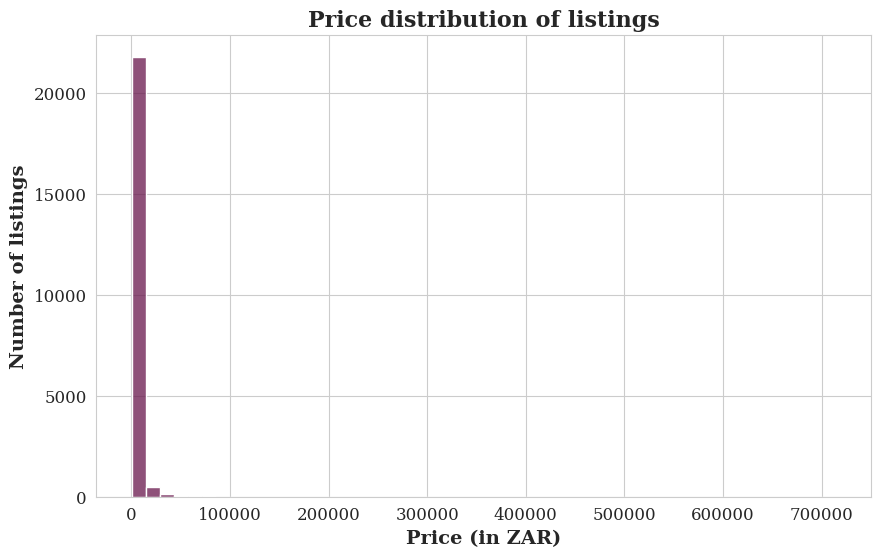

C:\Users\namit\AppData\Local\Temp\ipykernel_32608\821313577.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=listings_df,x='room_type',
C:\Users\namit\AppData\Local\Temp\ipykernel_32608\821313577.py:11: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.countplot(data=listings_df,x='room_type',


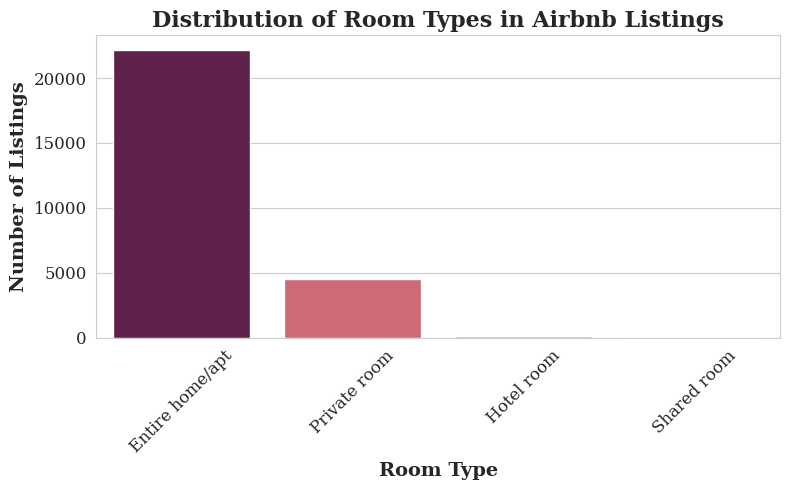

In [23]:
# Histogram of price
plt.figure(figsize=(10,6))
sns.histplot(listings_df['price'].dropna(), bins=50,color=palette[0], kde=False)
plt.title("Price distribution of listings")
plt.xlabel("Price (in ZAR)")
plt.ylabel("Number of listings")
plt.show()

# Countplot for room types
plt.figure(figsize=(8,5))
sns.countplot(data=listings_df,x='room_type',
              order=listings_df['room_type'].value_counts().index,
              palette=palette)
plt.title("Distribution of Room Types in Airbnb Listings")
plt.xlabel("Room Type")
plt.ylabel("Number of Listings")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observations and insights**
- Most listings are Entire Home/Apartments, followed by Private Rooms. Shared Rooms are rare, indicating limited low-cost sharing options.
- Price appears to show extreme outliers. Capping the price to a nominal 10,000 ZAR or using a log scale is essential in the preprocessing stage to enable further analysis.

# Summary table of datasets

In [29]:
# Summarise the insights from the datasets
summary_data = {
    "Dataset": ["Listings", "Calendar", "Neighbourhoods"],
    "Rows": [listings_df.shape[0], calendar_df.shape[0], wards_gdf.shape[0]],
    "Columns": [listings_df.shape[1], calendar_df.shape[1], wards_gdf.shape[1]],
    "Missing Values (%)": [
        round(listings_df.isnull().sum().sum()/listings_df.size*100,2),
        round(calendar_df.isnull().sum().sum()/calendar_df.size*100,2),
        round(wards_gdf.isnull().sum().sum()/wards_gdf.size*100,2)
    ],
    "Key Limitations": [
        "Price ~16% missing, some columns can be dropped",
        "Price and adjusted_price 100% missing",
        "neighbourhood_group column 100% missing"
    ]
}

# Create a dataframe of the insights and display
summary_df = pd.DataFrame(summary_data)
summary_df

,Dataset,Rows,Columns,Missing Values (%),Key Limitations
0,Listings,26877,18,14.53,"Price ~16% missing, some columns can be dropped"
1,Calendar,9810109,7,28.57,Price and adjusted_price 100% missing
2,Neighbourhoods,116,3,33.33,neighbourhood_group column 100% missing


## Project Workflow

The analysis follows a clear end-to-end workflow:

**Listings** + **Calendar** + **Neighbourhoods** → **Exploratory Data Analysis (EDA)** → **Affordability Pressure Index**

- **Listings:** Raw Airbnb listing data including price, room type, and location.  
- **Calendar:** Booking availability and minimum/maximum night constraints.  
- **Neighbourhoods:** Spatial boundaries for aggregating listings.  
- **EDA:** Analyze patterns such as listing density, price distribution, and room types.  
- **Affordability Pressure Index:** Combines metrics to identify neighborhoods under housing pressure.

This schematic highlights the **story arc** of the project, moving from raw data to actionable insights.
